In [1]:
import pandas as pd
import numpy as np
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC

In [2]:
#Problem 1.a
biden = pd.read_csv('biden.csv')
y = biden['biden'].values
X = biden[['female', 'age', 'dem', 'rep', 'educ']].values
biden.head(3)

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)
btree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
btree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

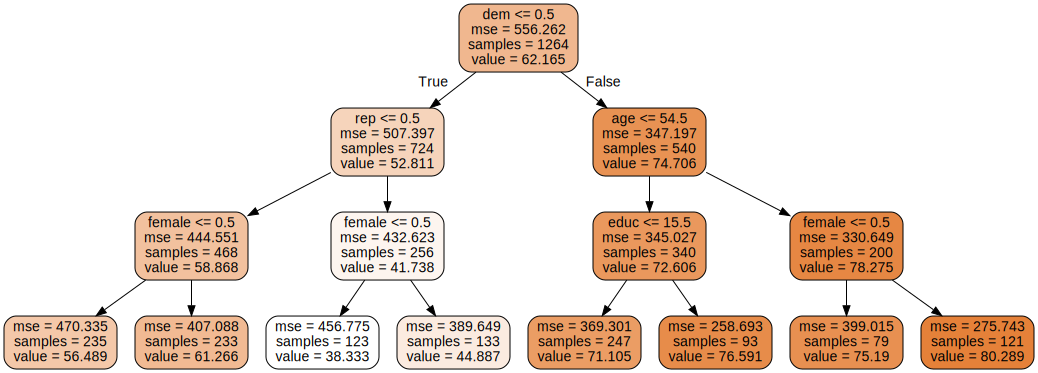

In [13]:
bid_tree_viz = export_graphviz(
    btree,
    out_file=None,
    feature_names=["female","age","dem","rep", "educ"],
    class_names=biden.biden,
    rounded=True,
    filled=True,
)
graph = graphviz.Source(bid_tree_viz)
graph.render('bid_tree_viz')
graph

The result shows the best binary splits and the decision tree splits the predictors into eight final nodes. First it splits on whether democrats or not, and then left branch splits again by whether republicans or not and then split by gender. The right branch splits by age first and then by education and gender.The MSE is 396.194.

In [14]:
y_pred = btree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE: ', MSE1)

MSE:  396.1937146321307


In [16]:
# Problem 1.b
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}
rs = RandomizedSearchCV(DecisionTreeRegressor(), param_dist1, n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
t1 = rs.fit(X_train, y_train)
t2 = rs.fit(X, y)
print("Training data:")
print('Best tuning parameter:', t1.best_params_)
print('MSE:', abs(t1.best_score_))
print("Complete dataset:")
print('Best tuning parameter:', t2.best_params_)
print('MSE:', abs(t2.best_score_))

Training data:
Best tuning parameter: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 9}
MSE: 404.7488359884144
Complete dataset:
Best tuning parameter: {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
MSE: 401.6903602232667


In [18]:
#Problem 1.c
b3 = RandomForestRegressor(bootstrap=True,oob_score=True, random_state=25)
param_dist2 = {'n_estimators': [10, 200],
               'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 5)}
rs2 = RandomizedSearchCV(b3, param_dist2,n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
t3 = rs2.fit(X_train, y_train)
t4 = rs2.fit(X, y)
print("Training data:")
print('Best tuning parameter:', t3.best_params_)
print('MSE:', abs(t3.best_score_))
print("Complete dataset:")
print('Best tuning parameter:', t4.best_params_)
print('MSE:', abs(t4.best_score_))

C:\Users\brend.000\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training data:
Best tuning parameter: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 397.2581460664323
Complete dataset:
Best tuning parameter: {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 397.2581460664323


In [23]:
#Problem 2.a
df = pd.read_csv('Auto.csv',na_values="?").dropna()
md = df['mpg'].median()
df['mpg_high'] = (df['mpg'] >= md).astype(int)
df['const'] = 1
df['orgn1'] = (df['origin'] == 1).astype(int)
df['orgn2'] = (df['origin'] == 2).astype(int)
Xvals = df[['cylinders', 'displacement', 'horsepower','weight','acceleration', 'year', 'orgn1', 'orgn2']].values
yvals = df['mpg_high'].values

kf = KFold(n_splits=4, shuffle=True, random_state=25)
kf.get_n_splits(Xvals)
e0 = np.zeros(4)
e1 = np.zeros(4)
MSE_vec = np.zeros(4)
k = 0

for train_index, test_index in kf.split(Xvals):
    print('k :', k)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    e0_pred = np.sum((y_test!=y_pred)&(y_test == 0))/np.sum(y_test == 0)
    e0[k] = e0_pred
    e1_pred = np.sum((y_test!=y_pred)&(y_test == 1))/np.sum(y_test == 1)
    e1[k] = e1_pred
    MSE_vec[k] = (y_test != y_pred).mean()
    print('Test set', k, ' MSE:', MSE_vec[k])
    print('error rate mpg_high = 1:', e1_pred)
    print('error rate mpg_high = 0:', e0_pred)
    k += 1

MSE_kf = MSE_vec.mean()
err1 = e1.mean()
err0 = e0.mean()
print('\nAverage MSE:', MSE_kf)
print('Average error rate mpg_high=1:', err1)
print('Average error rate mpg_high=0:', err0)

k : 0
Test set 0  MSE: 0.14285714285714285
error rate mpg_high = 1: 0.14545454545454545
error rate mpg_high = 0: 0.13953488372093023
k : 1
Test set 1  MSE: 0.09183673469387756
error rate mpg_high = 1: 0.07317073170731707
error rate mpg_high = 0: 0.10526315789473684
k : 2
Test set 2  MSE: 0.07142857142857142
error rate mpg_high = 1: 0.043478260869565216
error rate mpg_high = 0: 0.09615384615384616
k : 3
Test set 3  MSE: 0.08163265306122448
error rate mpg_high = 1: 0.05555555555555555
error rate mpg_high = 0: 0.11363636363636363

Average MSE: 0.09693877551020408
Average error rate mpg_high=1: 0.07941477339674582
Average error rate mpg_high=0: 0.11364706285146922


In [26]:
#Problem 2.b
param_dist3 = {'n_estimators': [10, 200],
               'max_depth': [3, 8],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features': sp_randint(1, 8)}
t =  RandomForestClassifier(bootstrap=True, oob_score=True, random_state=25)
rs3 = RandomizedSearchCV(t, param_dist3, n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error').fit(Xvals, yvals)
print('Best tuning parameter: ', rs3.best_params_)
print('MSE:', abs(rs3.best_score_))

Best tuning parameter:  {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 10}
MSE: 0.08928571428571429


C:\Users\brend.000\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\brend.000\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [31]:
#Problem 2.c
param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0), 'gamma': ['scale', 'auto'], 'shrinking': [True, False]}
rs4 = RandomizedSearchCV(SVC(kernel='rbf'), param_dist4, n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error').fit(Xvals, yvals)
print('Best tuning parameter:', rs4.best_params_)
print('MSE:', abs(rs4.best_score_))

Best tuning parameter: {'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}
MSE: 0.11989795918367346


d) The best predictor of mpg_high is Random Forest Classifier because it has the smallest MSE of 0.089.